# Hashcode 2022
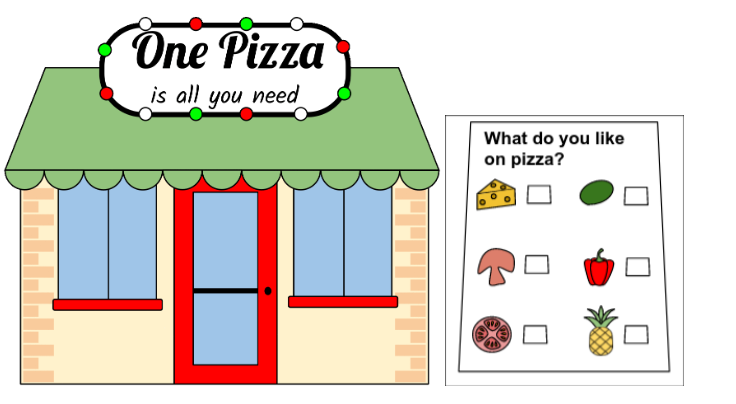

## Imports

In [1]:
from loader import Loader
import gurobipy as gp
from gurobipy import GRB
import numpy as np

path_problema = 'dataset/a_an_example.in.txt'

loader = Loader(path_problema)
loader.print()

num_ingredienti: 6
num_clients: 3
defaultdict(<function Loader.__init__.<locals>.<lambda> at 0x70e326d1c220>, {'cheese': [1, 0], 'peppers': [1, 0], 'basil': [1, 1], 'pineapple': [0, 1], 'mushrooms': [1, 0], 'tomatoes': [1, 0]})
defaultdict(<function Loader.__init__.<locals>.<lambda> at 0x70e3277534c0>, {'cheese': [[0], []], 'peppers': [[0], []], 'basil': [[1], [2]], 'pineapple': [[], [1]], 'mushrooms': [[2], []], 'tomatoes': [[2], []]})


In [2]:
model = gp.Model()

Restricted license - for non-production use only - expires 2025-11-24


# Variabili decisionali

$$
    x_{i} \\
    i \in [0, \dots, \text{numero di ingredienti}-1]
$$

$x_i$ variabilie decisionale binaria che indica se l'ingrediente i-esimo **e' presente o no nella pizza.**

In [3]:
x = model.addMVar(loader.num_ingredienti, vtype=GRB.BINARY, name="x")
x

<MVar (6,)>
array([<gurobi.Var *Awaiting Model Update*>,
       <gurobi.Var *Awaiting Model Update*>,
       <gurobi.Var *Awaiting Model Update*>,
       <gurobi.Var *Awaiting Model Update*>,
       <gurobi.Var *Awaiting Model Update*>,
       <gurobi.Var *Awaiting Model Update*>])

$$
y_j \\
j \in [0, \dots, \text{numero di clienti} - 1]
$$

$y_j$ variabile binaria che indica se il cliente j-esimo e' un possibile cliente o no della pizzeria

In [4]:
y = model.addMVar(loader.num_clients, vtype=GRB.BINARY, name="y")
y

<MVar (3,)>
array([<gurobi.Var *Awaiting Model Update*>,
       <gurobi.Var *Awaiting Model Update*>,
       <gurobi.Var *Awaiting Model Update*>])

# Vincoli
Per ogni possibile cliente abbiamo due vincoli:
1. Tutti gli ingredienti che piacciono sono presenti nella ricetta
2. Nessuno degli ingredienti che non piacciono sono presenti

## Vincolo sugli ingredienti preferiti
$$
    \hat x L_j \geq \sum_{i=0}^{\text{num. ingr}}L_j  y_j \\
    \forall j \in [0, \dots, \text{numero di clienti} - 1]
$$

dove $L_j$ e' un vettore colonna sparso che rappresenta gli ingredienti che piacciono all'utente quindi nella forma
$$
[0,1,\dots,1,0]^t
$$
Con il vincolo del problema che la somma del vettore \`e un numero compreso tra 1 e 5 
$$
1 \leq \sum_{i=0}^{\text{num. ingr}}L_j \leq 5 
$$

```
Possiamo anche calcolare come prodotto scalare con entrambi vettori riga invece di utilizzare prodotto matriciale
```

Mentre il vettore $\hat x$ rappresenta il vettore riga soluzione

In [5]:
clients_sparse = loader.sparse_rappresentation()
print(clients_sparse)

[{'liked': [1, 1, 0, 0, 0, 0], 'disliked': [0, 0, 0, 0, 0, 0]}, {'liked': [0, 0, 1, 0, 0, 0], 'disliked': [0, 0, 0, 1, 0, 0]}, {'liked': [0, 0, 0, 0, 1, 1], 'disliked': [0, 0, 1, 0, 0, 0]}]


In [6]:
for j, client in enumerate(clients_sparse):
    model.addConstr(x @ np.array(client["liked"]).T  >= np.sum(client["liked"]) * y[j])

## Vincolo su ingredienti che non piacciono

Per verificare che nessuno degli ingredienti che non piacciono sono presenti nella soluzone basta verificare che il prodotto matriciale tra il vettore soluzione e il vettore disliked dia un valore nullo
$$
\hat x D_J + 1 \leq M (1 - y_j)
$$
dove M e' un valore abbastanza grande in modo da rendere sempre vera l'equzione nel caso $y_j = 0$, quindi nel caso del cliente j-esimo non considerato come possibile cliente

In [7]:
for j, client in enumerate(clients_sparse):
    model.addConstr(x @ np.array(client['disliked']).T <= loader.num_ingredienti * (1 - y[j]))

# Funzione obiettivo

La funzione obiettivo e' massimizzare il numero di possibili clienti
$$
max(\sum_{j=0}^{\text{num. clienti}} y_j)
$$

In [8]:
model.setObjective(y.sum(), GRB.MAXIMIZE)

In [9]:
model.write('onepizza.lp')

# Soluzioni

In [10]:
model.optimize()

if model.Status == GRB.OPTIMAL:
    with open(path_problema.strip('txt') + 'solved.txt', 'w') as f:
        f.write(f"{[tmp.X for tmp in  x.tolist()]} \n")
        f.write(f"{model.ObjVal}")

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Arch Linux")

CPU model: Intel(R) Core(TM) i5-5200U CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 6 rows, 9 columns and 13 nonzeros
Model fingerprint: 0xccfc2c48
Variable types: 0 continuous, 9 integer (9 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+00, 6e+00]
Found heuristic solution: objective -0.0000000
Found heuristic solution: objective 2.0000000
Presolve removed 6 rows and 9 columns
Presolve time: 0.24s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.77 seconds (0.00 work units)
Thread count was 1 (of 4 available processors)

Solution count 2: 2 -0 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+00, best bound 2.000000000000e+00, gap 0.0000%
